``https://github.com/hhk998402/Time-Series-Forecasting-SARIMAX/blob/master/Hemant_Sangam.ipynb``

<b>Approach used:</b> SARIMAX (Seasonal Autoregressive Integrated Moving Average with eXogeneous variables)

<b> Reason:</b> The data provided is seasonal, and it is a time series data with multiple exogeneous variables influencing the result. Hence, the optimal statistical model that can be applied to this task is SARIMAX

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

Open and store the dataset as a pandas dataframe

In [2]:
# get data
df = pd.read_csv("../data/complete-merged-df.csv", index_col=0, parse_dates=True)
df.head()

,close,open,high,low,estimated-transaction-volume-usd,n-transactions,hash-rate,difficulty,cost-per-transaction,Gold price,output-volume,trade-volume,USD-CNY Price,SVI,Wikiviews
2017-01-01,998.079443,966.567909,1005.074602,961.719392,1.667890e+08,180502.0,2.463611e+06,3.176884e+11,10.914479,1377.316553,1.084341e+06,3.989748e+06,6.72991,7.000000,3139
2017-01-02,1018.369458,998.079638,1033.051602,994.997792,2.799811e+08,290951.0,2.526780e+06,3.176884e+11,7.350606,1294.600000,1.573982e+06,6.822471e+06,6.94500,18.574713,9165
2017-01-03,1036.750461,1018.367417,1037.211425,1014.576142,3.417543e+08,301664.0,2.589950e+06,3.176884e+11,7.415466,1295.600000,1.950525e+06,8.324526e+06,6.96100,18.574713,12354
2017-01-04,1137.239897,1036.750186,1146.956329,1036.327096,4.336781e+08,328642.0,2.432026e+06,3.176884e+11,7.000531,1287.300000,2.482038e+06,9.340584e+06,6.93510,18.574713,10757
2017-01-05,1002.860000,1137.239606,1165.785631,883.480930,5.657800e+08,288501.0,2.210933e+06,3.176884e+11,6.913398,1287.400000,2.998215e+06,2.387011e+07,6.89000,18.574713,11938


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2017-01-01 to 2021-12-31
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   close                             1826 non-null   float64
 1   open                              1826 non-null   float64
 2   high                              1826 non-null   float64
 3   low                               1826 non-null   float64
 4   estimated-transaction-volume-usd  1826 non-null   float64
 5   n-transactions                    1826 non-null   float64
 6   hash-rate                         1826 non-null   float64
 7   difficulty                        1826 non-null   float64
 8   cost-per-transaction              1826 non-null   float64
 9   Gold price                        1826 non-null   float64
 10  output-volume                     1826 non-null   float64
 11  trade-volume                      1826 non-null   f

## Helper methods

In [5]:
# Accuracy metrics
import yfinance as yf
from yahoofinancials import YahooFinancials
from datetime import date

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]   # corr
    mins = np.amin(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return({'mape': str(round(mape*100, 3))+"%", 'me': me, 'mae': mae,
            'mpe': mpe, 'rmse': rmse,
            'corr': corr, 'minmax': minmax})


# get new data from yahoo finance
def get_new_data(ticker, start_date, end_date=date.today()):
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    return data


def plot_future(past, predicted, actual):
    plt.figure(figsize=(12, 8))
    plt.plot(predicted, label='Predicted Stock Price')
    plt.plot(actual, color='g', label='Actual Future Stock Price')
    plt.plot(past, color='r', label='Actual Stock Price')

    plt.axvline(x=max(past.index),
                color='green', linewidth=2, linestyle='--')
    plt.xticks(rotation=45, fontsize=8)
    plt.legend(shadow=True, loc='upper right')

## Prepare the data:

- Split the data into train and test samples
- Create `endog` and `exog` variables


In [6]:
# split data into train and test
top_predictors = ['close','open', 'high', 'low', 'n-transactions', 'cost-per-transaction',
                  'Gold price', 'output-volume',  'USD-CNY Price', 'SVI', 'Wikiviews']
df = df[top_predictors]

train, test = train_test_split(df, test_size=0.2, shuffle=False)
# len(train), len(test)

# Variables
exog_data = train.drop(['close'], axis=1)

exog = sm.add_constant(exog_data)
endog = train[['close']]

# # try shifting by 1 to see if it helps
# # NOTE: this is not working
# endog = train[['close']].shift(-1) 
# endog.fillna(endog.iloc[-2].values[0], inplace=True)


## Find the best order for the ARIMA model

In [140]:
# Initial approximation of parameters
Qs = range(0, 3)
qs = range(0, 4)
Ps = range(0, 4)
ps = range(0, 4)
D = 1
d = 1
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(endog, exog=exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])


In [141]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())
print(best_model.summary())


       parameters           aic
134  (2, 3, 0, 2)  19166.363496
182  (3, 3, 0, 2)  19166.867938
74   (1, 2, 0, 2)  19180.614298
137  (2, 3, 1, 2)  19182.344922
185  (3, 3, 1, 2)  19192.256249
                                       SARIMAX Results                                        
Dep. Variable:                                  close   No. Observations:                 1460
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 4)   Log Likelihood               -9560.182
Date:                                Fri, 15 Apr 2022   AIC                          19166.363
Time:                                        19:33:28   BIC                          19287.867
Sample:                                    01-01-2017   HQIC                         19211.697
                                         - 12-30-2020                                         
Covariance Type:                                  opg                                         
                                       coef    s

## Build Model

In [148]:
# train model

# , seasonal_order=(0, 1, [1, 2], 4)
# sar = SARIMAX(endog, exog=exog, order=(2, 1, 3))
# seasonal_order=(0, 1, [1], 4)
sar = SARIMAX(endog, exog=exog, order=(1, 1, 2))
model = sar.fit(disp=False)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1460
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -9421.055
Date:                Sat, 16 Apr 2022   AIC                          18872.110
Time:                        19:02:41   BIC                          18951.392
Sample:                    01-01-2017   HQIC                         18901.686
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -8.861e-17   9.34e-05  -9.49e-13      1.000      -0.000       0.000
open                    -0.4896      0.008    -64.209      0.000      -0.505      -0.475
high                     0.8234      0.008     99.870      0.000       0.807       0.840
low                      0.6300      0.004    149.244      0.000       0.622       0.638
n-transactions           0.0002      0.000      1.539      0.124   -5.94e-05       0.000
cost-per-transaction    -1.4227      0.481     -2.959      0.003      -2.365      -0.480
Gold price              -0.0264      0.045     -0.586      0.558      -0.115       0.062
output-volume         -1.22e-06   6.77e-06     -0.180      0.857   -1.45e-05    1.21e-05
USD-CNY Price          -52.4125     39.150     -1.339      0.181    -129.146      24.321
SVI                     -1.0452      0.516     -2.027      0.043      -2.056      -0.035
Wikiviews                0.0002      0.000      0.816      0.414      -0.000       0.001
ar.L1                   -0.9041      0.038    -23.863      0.000      -0.978      -0.830
ma.L1                   -0.0382      0.042     -0.905      0.365      -0.121       0.045
ma.L2                   -0.7632      0.043    -17.899      0.000      -0.847      -0.680
sigma2                2.442e+04      0.569   4.29e+04      0.000    2.44e+04    2.44e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.68   Jarque-Bera (JB):             12850.28
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.83e+22. Standard errors may be unstable.
"""

In [8]:
# adfuller test
print("Dickey–Fuller test:: p=%f" % sm.tsa.adfuller(model.resid[13:])[1])


Dickey–Fuller test:: p=0.000000


Display the residuals from the model fit in acf and pacf plots

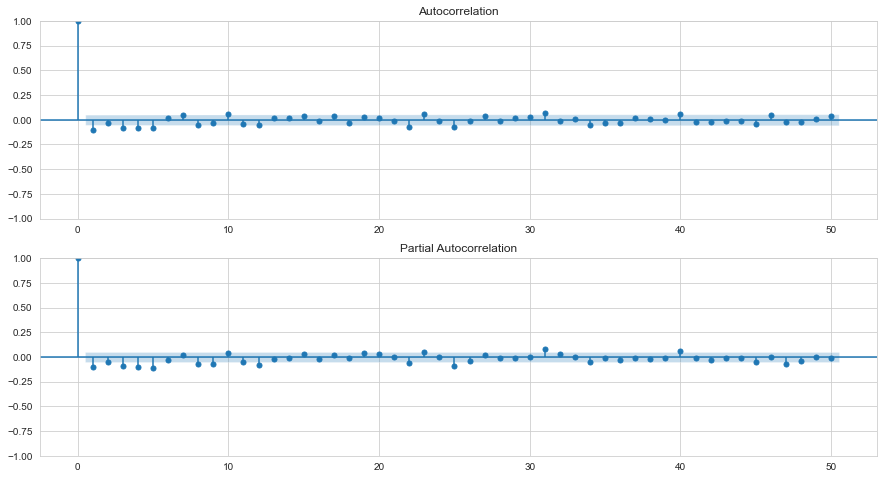

In [9]:
res = model.resid
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [207]:
pd.DataFrame(model.resid, columns=['resid']).sort_values(by='resid', ascending=False).head(5)


,resid
2017-12-22,1150.321211
2017-12-08,1008.528725
2020-12-29,983.444675
2017-12-07,874.207812
2018-01-17,850.453636


The outlier in date `2017-12-22`?

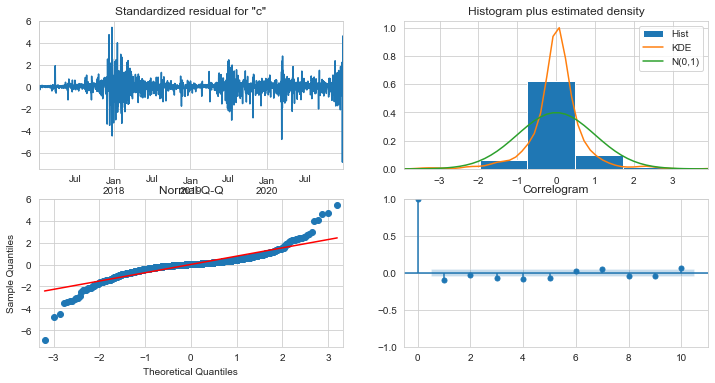

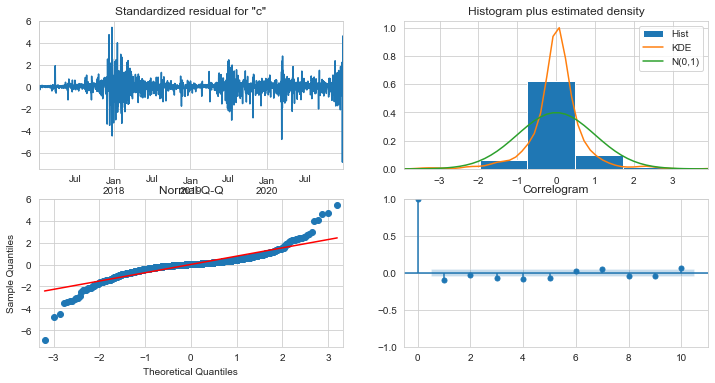

In [145]:
model.plot_diagnostics(figsize=(12, 6))

## Now lets test the model's prediction

In [149]:
# test model
first_predict, last_predict = test.iloc[0].name, test.iloc[-1].name

exog1 = (sm.add_constant(test).loc[first_predict:])
exog1 = exog1.drop(['close'], axis=1)

forecast = model.forecast(steps=len(test), exog=exog1)
result_data = pd.DataFrame(index=test.index, columns=['actual', 'pred'])

# display the forecast accuracy metrics for the test set
print(forecast_accuracy(forecast, test['close'].values))

chk = 0
for i in forecast:
    result_data.iloc[chk]["actual"] = df.iloc[df.index == test.iloc[chk].name]['close'].values[0]
    result_data.iloc[chk]["pred"] = i
    chk += 1
    
result_data.head()

{'mape': '2.12%', 'me': -865.9803092147691, 'mae': 1021.3524550258411, 'mpe': -0.01726456417407128, 'rmse': 1255.5720712064083, 'corr': 0.9963374073147964, 'minmax': 0.021141799797968375}


,actual,pred
2020-12-31,28984.983403,28481.029793
2021-01-01,29405.123461,29223.057507
2021-01-02,32216.53,32125.631259
2021-01-03,33071.5,33887.968626
2021-01-04,32042.188855,29956.996532


We can see the predicted values are quite close to the actual values

<AxesSubplot:>

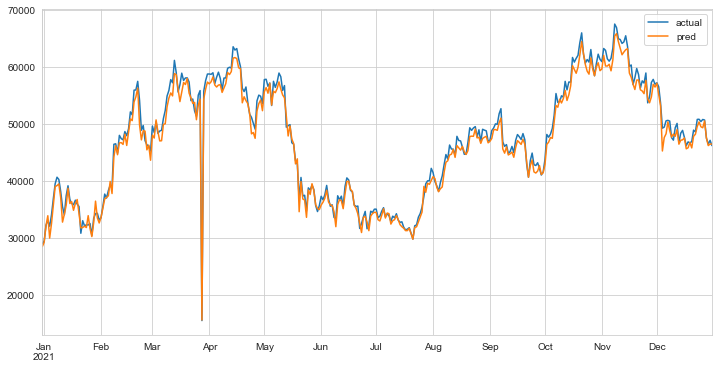

In [130]:
result_data.plot(figsize=(12, 6))

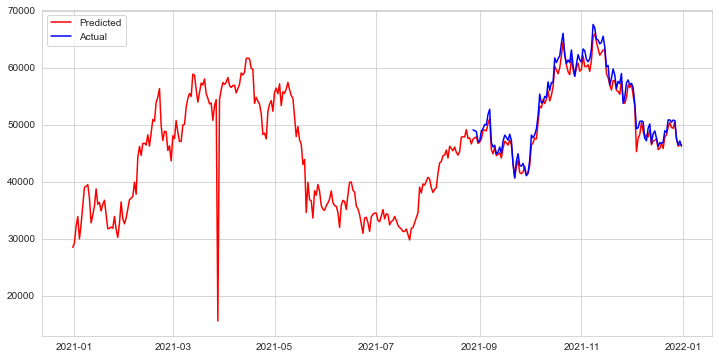

In [60]:
# plot the test data and the predicted data
plt.figure(figsize=(12, 6))

plt.plot(result_data['pred'], label='Predicted', color='red')
plt.plot(df[1700:]['close'], label='Actual', color='blue')

plt.legend(loc='upper left')


The blue label depicts the actual values, while the red label shows the prediction made. <br>
The plot shows us the model has predicted the values closely to the actual values.

### Forecast Tests
- Make a prediction using the model for the next `n-days/months/years`.
- The `get_new_data()` function gets the BPI from Yahoo Finance for the latest/given dates to compare with the predictions.
- Create a `future` DataFrame with the actual and forecasted values
- Create a mask for a short time frame and visualize it in a plot
- Calculate metrics

In [140]:
from dateutil.relativedelta import relativedelta

# create a list of dates to predict
exog_last = sm.add_constant(df.drop(['close'], axis=1))
start_index = exog_last.index.max().date()
end_index = start_index + relativedelta(days=30)

print("start_index:", start_index)
print("end_index:", end_index)

# predict using the fitted model
yhat5 = model.predict(start=start_index, end=end_index - relativedelta(days=25), exog=exog_last[-371:])
yhat10 = model.predict(start=start_index, end=end_index - relativedelta(days=20), exog=exog_last[-376:])
yhat30 = model.predict(start=start_index, end=end_index, exog=exog_last[-396:])
yhat60 = model.predict(start=start_index, end=end_index + relativedelta(days=30), exog=exog_last[-426:])

start_index: 2021-12-31
end_index: 2022-01-30


In [132]:
# get present values 
yhat_actual = get_new_data('BTC-USD', df.index[-1])

# create a new dataframe with the actual and predicted values
future = pd.DataFrame(columns=['actual'])
future['forecast10'] = yhat10
future['forecast30'] = yhat30
future['forecast60'] = yhat60
future["actual"] = yhat_actual['Close']

# NOTE: tested by deducting the MAE on the forecasted values
# future['forecast'] = future['forecast'].apply(lambda x: x - 16275)
future.head()


,actual,forecast10,forecast30,forecast60
2021-12-31,46306.445312,47845.039948,57149.054088,59667.150609
2022-01-01,47686.812500,48201.555539,55209.902395,62052.817137
2022-01-02,47345.218750,49578.545017,53168.171355,60191.845429
2022-01-03,46458.117188,50358.848188,45260.227538,60180.202541
2022-01-04,45897.574219,49515.097390,47620.452642,60492.431587


<AxesSubplot:title={'center':'Bitcoin Price Prediction'}>

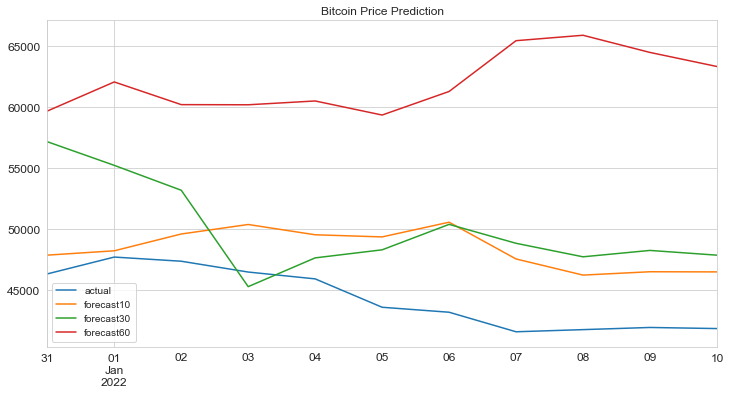

In [133]:
# compare predicted values with actual values
future.plot(figsize=(12, 6), title='Bitcoin Price Prediction', grid=True, legend=True, fontsize=12)

# The lower the MSE, the better the forecast.
# forecast_accuracy(future['forecast10'], future['actual'])
# forecast_accuracy(future['forecast30'], future['actual'])
# forecast_accuracy(future['forecast60'], future['actual'])

,Actual,Forecast_30,Forecast_60,Past (y-1)
date,,,,
2022-01-01,47686.812500,55209.902395,62052.817137,29405.123461
2022-01-02,47345.218750,53168.171355,60191.845429,32216.530000
2022-01-03,46458.117188,45260.227538,60180.202541,33071.500000
2022-01-04,45897.574219,47620.452642,60492.431587,32042.188855
2022-01-05,43569.003906,48280.617226,59338.283806,34043.030762


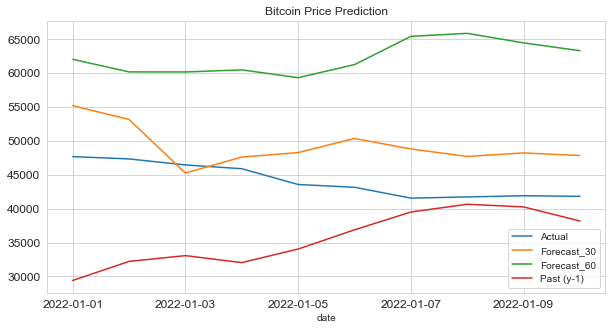

In [150]:
# create a list of data for each month in the future with the 
# date, actual value, and predicted value, and the past value on this date a year ago
cc = []
for i in range(1, 32):
    for j in range(1, 4):
        try:
            d = f'2022-0{j}-{i < 10 and f"0{i}" or i}'
            cc.append({
                    'date': d, 
                    'Forecast_30': future.iloc[future.index == d]['forecast30'].values[0],
                    'Forecast_60': future.iloc[future.index == d]['forecast60'].values[0],
                    'Actual': yhat_actual.iloc[yhat_actual.index == d]['Close'].values[0],
                    'Past (y-1)': df.iloc[df.index == f'2021-0{j}-{i < 10 and f"0{i}" or i}']['close'].values[0]
            })
        except IndexError as e:
            continue

# merge the list of dictionaries into a dataframe
y_april = pd.DataFrame(cc, columns=['date','Actual', 'Forecast_30','Forecast_60','Past (y-1)'])
y_april.set_index('date', inplace=True)
y_april.sort_index(inplace=True)
y_april.plot(figsize=(10, 5), title='Bitcoin Price Prediction', grid=True, legend=True, fontsize=12)
y_april.head()

<AxesSubplot:title={'center':'Bitcoin Price Prediction'}, xlabel='date'>

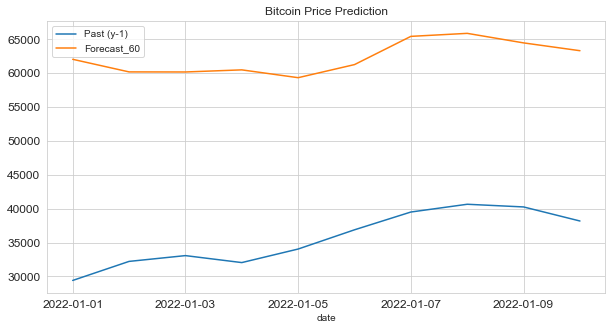

In [152]:
y_april['Past (y-1)'].plot(figsize=(10, 5), title='Bitcoin Price Prediction', grid=True, legend=True, fontsize=12)
y_april['Forecast_60'].plot(figsize=(10, 5), title='Bitcoin Price Prediction', grid=True, legend=True, fontsize=12)

The results indicate that the model is still a little rough and not something we should use as trading advice, but that was not unexpected due to the extremely volatile nature of cryptocurrencies, especially in the last 6 months.

It is probably also not such a good idea to try and predict 6 months into the future as we can see how insane even the 80% confidence interval becomes out this far. Maybe sticking to 1 month advance predictitons is more sensible. Or maybe even predicting on a daily basis.

In [147]:
def make_future_df(pred, actual):
    future_df = pd.DataFrame(columns=['actual', 'forecast'])
    future_df['forecast'] = pred
    future_df['actual'] = actual
    accuracy = forecast_accuracy(future_df['forecast'], future_df['actual'])

    return future_df, accuracy

future5, acc5 = make_future_df(yhat5, yhat_actual['Close'])
future10, acc10 = make_future_df(yhat10, yhat_actual['Close'])
future30, acc30 = make_future_df(yhat30, yhat_actual['Close'])
future60, acc60 = make_future_df(yhat60, yhat_actual['Close'])

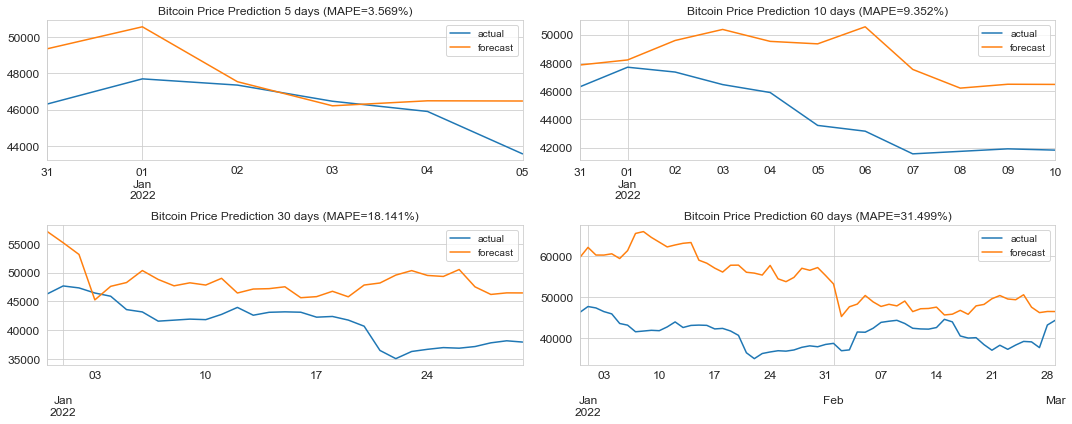

In [135]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2)
fig.figure.set_size_inches(15, 6)

fig = future5.plot(ax=ax1, title=f'Bitcoin Price Prediction 5 days (MAPE={acc5["mape"]})', grid=True, legend=True, fontsize=12)
fig = future10.plot(ax=ax2, title=f'Bitcoin Price Prediction 10 days (MAPE={acc10["mape"]})', grid=True, legend=True, fontsize=12)
fig = future30.plot(ax=ax3, title=f'Bitcoin Price Prediction 30 days (MAPE={acc30["mape"]})', grid=True, legend=True, fontsize=12)
fig = future60.plot(ax=ax4, title=f'Bitcoin Price Prediction 60 days (MAPE={acc60["mape"]})', grid=True, legend=True, fontsize=12)
plt.tight_layout()

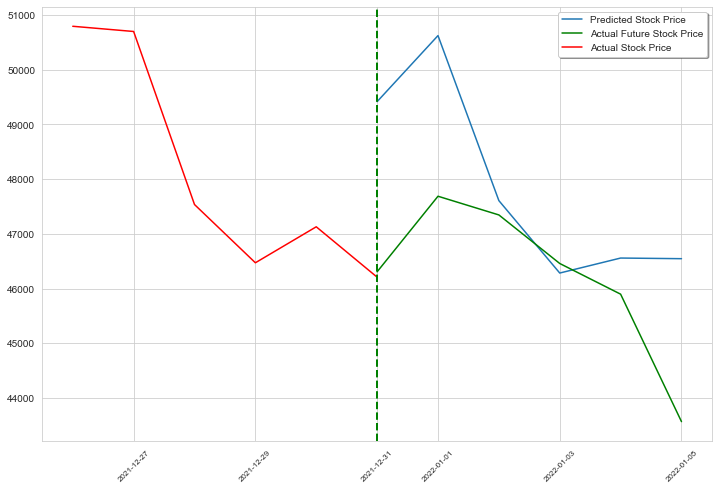

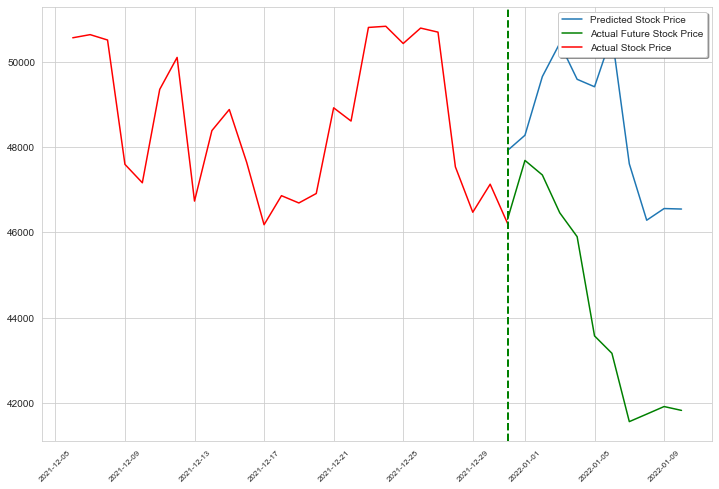

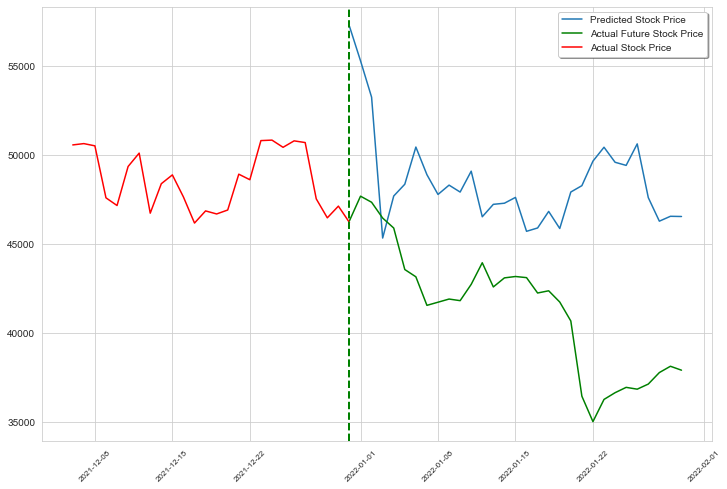

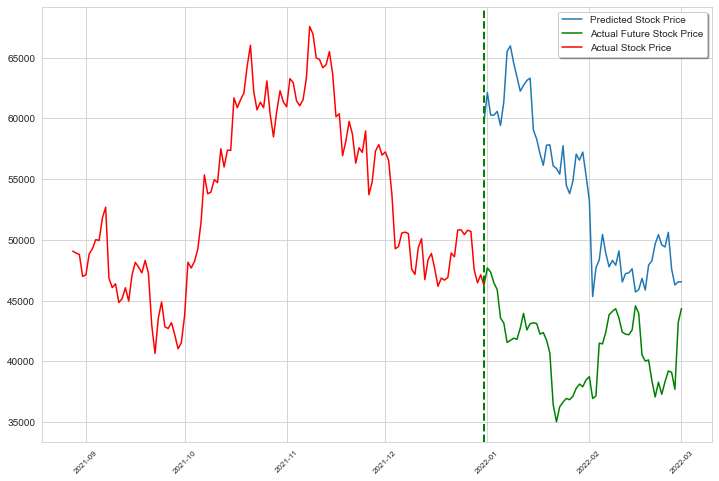

In [127]:
plot_future(df[1820:].close, future5['forecast'], future5['actual'])
plot_future(df[1800:].close, future10['forecast'], future10['actual'])
plot_future(df[1800:].close, future30['forecast'], future30['actual'])
plot_future(df[1700:].close, future60['forecast'], future60['actual'])